In [1]:
import pandas
import geopandas

import os, sys
sys.path.append(os.path.abspath(''))

from functions import get_raw_path, get_data_path, store_context_data, open_geopandas_csv,\
                      add_neighbourhood_column, print_df_columns, open_geopandas_csv, geom_dict_to_shape,\
                      get_neighbourhoods, get_gdf_using_geom_dict, get_overlay
import functions

import re

import numpy as np

In [ ]:
raise Exception("Do not run all cells! -> This will overwrite the pre-reformated data!")

# Traffic Volumes

In [9]:
FILE_NAME = 'raw-data-2010-2019.csv'

STORE_NAME = 'Traffic Volumes.csv'

df = pandas.read_csv(get_raw_path(FILE_NAME))

# df.head()

The coordinates are stored in columns 'lng' and 'lat'

In [10]:
gdf = geopandas.GeoDataFrame(df.drop(['lng', 'lat'], axis=1), geometry=geopandas.points_from_xy(df['lng'], df['lat']))
gdf.crs = functions.CRS

gdf_raw = gdf

In [13]:
missing = gdf_raw.index.difference(gdf.index)

print(missing)

RangeIndex(start=0, stop=0, step=1)


In [4]:
gdf = add_neighbourhood_column(gdf)

Joining now using: 'how=inner', 'predicate=within'


In [5]:
gdf.head()

,_id,count_id,count_date,location_id,location,centreline_type,centreline_id,px,time_start,time_end,...,nx_bike,sx_bike,ex_bike,wx_bike,nx_other,sx_other,ex_other,wx_other,geometry,Neighbourhood
0,1,25081,2010-01-12,32187,LILLIAN ST AT SOUDAN AVE,2.0,13457294.0,NaN,2010-01-12T07:30:00,2010-01-12T07:45:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-79.39326 43.70528),174
1,2,25081,2010-01-12,32187,LILLIAN ST AT SOUDAN AVE,2.0,13457294.0,NaN,2010-01-12T07:45:00,2010-01-12T08:00:00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,POINT (-79.39326 43.70528),174
2,3,25081,2010-01-12,32187,LILLIAN ST AT SOUDAN AVE,2.0,13457294.0,NaN,2010-01-12T08:00:00,2010-01-12T08:15:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-79.39326 43.70528),174
3,4,25081,2010-01-12,32187,LILLIAN ST AT SOUDAN AVE,2.0,13457294.0,NaN,2010-01-12T08:15:00,2010-01-12T08:30:00,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,POINT (-79.39326 43.70528),174
4,5,25081,2010-01-12,32187,LILLIAN ST AT SOUDAN AVE,2.0,13457294.0,NaN,2010-01-12T08:30:00,2010-01-12T08:45:00,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,POINT (-79.39326 43.70528),174


In [6]:
gdf['Neighbourhood'].isna().sum()

0

In [7]:
store_context_data(gdf, STORE_NAME)

In [8]:
gdf = open_geopandas_csv(get_data_path(STORE_NAME))

gdf.head()

# gdf.loc[:100].explore()

,Unnamed: 0,_id,count_id,count_date,location_id,location,centreline_type,centreline_id,px,time_start,...,nx_bike,sx_bike,ex_bike,wx_bike,nx_other,sx_other,ex_other,wx_other,Neighbourhood,geometry
0,0,1,25081,2010-01-12,32187,LILLIAN ST AT SOUDAN AVE,2.0,13457294.0,NaN,2010-01-12T07:30:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,174,POINT (-79.39326 43.70528)
1,1,2,25081,2010-01-12,32187,LILLIAN ST AT SOUDAN AVE,2.0,13457294.0,NaN,2010-01-12T07:45:00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,174,POINT (-79.39326 43.70528)
2,2,3,25081,2010-01-12,32187,LILLIAN ST AT SOUDAN AVE,2.0,13457294.0,NaN,2010-01-12T08:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,174,POINT (-79.39326 43.70528)
3,3,4,25081,2010-01-12,32187,LILLIAN ST AT SOUDAN AVE,2.0,13457294.0,NaN,2010-01-12T08:15:00,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,174,POINT (-79.39326 43.70528)
4,4,5,25081,2010-01-12,32187,LILLIAN ST AT SOUDAN AVE,2.0,13457294.0,NaN,2010-01-12T08:30:00,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,174,POINT (-79.39326 43.70528)


# Centrelines
Because this consists of lines, we use 'intersects' predicate over 'within' to match it.

Therefore an additional columns are added:

- NeighbourhoodPortion (the portion of the MultiLineString's full length that lies within the neighbourhood)

In [29]:
FILE_NAME  = "Centreline - Version 2 - 4326.csv"
STORE_NAME = "Centrelines.csv"

df = pandas.read_csv(get_raw_path(FILE_NAME))

df.head()

,_id,CENTRELINE_ID,LINEAR_NAME_ID,LINEAR_NAME_FULL,LINEAR_NAME_FULL_LEGAL,ADDRESS_L,ADDRESS_R,PARITY_L,PARITY_R,LO_NUM_L,...,TO_INTERSECTION_ID,ONEWAY_DIR_CODE,ONEWAY_DIR_CODE_DESC,FEATURE_CODE,FEATURE_CODE_DESC,JURISDICTION,CENTRELINE_STATUS,OBJECTID,MI_PRINX,geometry
0,1,914600,2141,Morrison St,Morrison Street,NaN,NaN,N,N,NaN,...,13470560,0,Not One-Way,201500,Local,CITY OF TORONTO,NaN,1,1,"{'type': 'MultiLineString', 'coordinates': [[[..."
1,2,914601,2666,Twelfth St,Twelfth Street,66-92,65-89,E,O,66.0,...,13470530,0,Not One-Way,201500,Local,CITY OF TORONTO,NaN,2,2,"{'type': 'MultiLineString', 'coordinates': [[[..."
2,3,7862398,2611,Thirteenth St,Thirteenth Street,66-96,65-91,E,O,66.0,...,13470538,0,Not One-Way,201500,Local,CITY OF TORONTO,NaN,3,3,"{'type': 'MultiLineString', 'coordinates': [[[..."
3,4,914587,1962,Lake Shore Blvd W,Lake Shore Boulevard West,NaN,3180-3180,N,E,NaN,...,13470552,0,Not One-Way,201200,Major Arterial,CITY OF TORONTO,NaN,6,6,"{'type': 'MultiLineString', 'coordinates': [[[..."
4,5,6735911,1962,Lake Shore Blvd W,Lake Shore Boulevard West,3197-3197,3190-3190,O,E,3197.0,...,13470558,0,Not One-Way,201200,Major Arterial,CITY OF TORONTO,NaN,7,7,"{'type': 'MultiLineString', 'coordinates': [[[..."


In [30]:
gdf = get_gdf_using_geom_dict(df)

Processing geometry column...
Creating GeoDataFrame


In [31]:
## Get the neighbourhood dataset
neighbourhood = get_neighbourhoods()

print("Joining...")
## Merge the gdf with the neighbourhood stuff
joined = geopandas.sjoin(gdf.to_crs(functions.CRS), neighbourhood.to_crs(functions.CRS), how='inner', predicate='intersects').to_crs(epsg = functions.EPSG)

print("Filtering rows...")
## Filter out any un-matched columns
gdf = gdf.loc[joined.index]

print("Calculating NeighbourhoodPortions")
## Add the 'NeighbourhoodPortion' column
geometry_right = neighbourhood.to_crs(epsg=functions.EPSG).loc[joined['index_right']].set_index(joined.index)
numerator = np.array(joined.geometry.intersection(geometry_right).length)
denomenator = np.array(joined.geometry.length)
gdf['NeighbourhoodPortion'] =  numerator / denomenator 

print("Assigning Neighbourhood")
## Add the Neighbourhood column
gdf['Neighbourhood'] = joined['index_right']

## Drop where they are right on the border, and not inside... so NeighbourhoodPortion is 0
gdf = gdf.loc[gdf['NeighbourhoodPortion'] != 0]

Joining...
Filtering rows...
Calculating NeighbourhoodPortions
Assigning Neighbourhood


In [33]:
len(gdf)

75435

In [34]:
store_context_data(gdf, STORE_NAME)

# Intersections
Some intersections lie on the border between neighbourhoods, so an additional field is added:
- SingleNeighbourhood: 1 if point lies entirely within a single neighbourhood

In [ ]:
FILE_NAME  = "Centreline Intersection - 4326.csv"
STORE_NAME = "Intersections.csv"

df = pandas.read_csv(get_raw_path(FILE_NAME))

df.head()

In [ ]:
gdf = get_gdf_using_geom_dict(df)

# gdf.head()

In [ ]:
gdf_fully_within = add_neighbourhood_column(gdf)
gdf_fully_within['SingleNeighbourhood'] = np.ones(len(gdf_fully_within))

print("Searching for missing...")
missing_indexes = gdf.index.difference(gdf_fully_within.index)
missing = gdf.loc[missing_indexes]
print(len(missing))

gdf_bordering = add_neighbourhood_column(missing, predicate='intersects')
gdf_bordering['SingleNeighbourhood'] = np.zeros(len(gdf_bordering))
print("Bordering: ", len(gdf_bordering))

print("Searching for final missing ones...")
missing_indexes = missing.index.difference(gdf_bordering.index)
missing = missing.loc[missing_indexes]
print(len(missing))

# missing.head()
print("Combining now...")
gdf = geopandas.GeoDataFrame(pandas.concat([
    gdf_fully_within,
    gdf_bordering
])).set_geometry('geometry').to_crs(functions.CRS)

In [ ]:
# missing.explore()

In [ ]:
store_context_data(gdf, STORE_NAME)

# Weather data
Working with the latest thing uploaded by Curtis
Some datapoints removed as they were outside city (run missing_gdf.explore() below to see on map)

In [ ]:
FILE_NAME = 'climate-daily-2.csv'
STORE_NAME = 'Climate.csv'

df = pandas.read_csv(get_raw_path(FILE_NAME), low_memory=False)

df.head()

In [ ]:
gdf = geopandas.GeoDataFrame(df.drop(['x', 'y'], axis=1), geometry=geopandas.points_from_xy(df['x'], df['y']))
gdf.crs = functions.CRS

In [ ]:
gdf_2 = add_neighbourhood_column(gdf)

In [ ]:
missing = gdf.index.difference(gdf_2.index)

In [ ]:
missing_gdf = get_overlay(get_neighbourhoods(), 'nbhood', gdf.loc[missing], 'Weather Station')

In [ ]:
missing_gdf.explore()

In [ ]:
store_context_data(gdf_2, STORE_NAME)

# Traffic Calming Database
Some features here also cross between neighbourhoods. Add the same feature:
- NeighbourhoodPortion

1 value without the geometry feature added...

In [46]:
FILE_NAME = 'Traffic Calming Database.zip'
STORE_NAME = 'Traffic Calming.csv'

gdf = geopandas.read_file(get_raw_path(FILE_NAME))
gdf = gdf.to_crs(functions.CRS)
gdf.head()

,calm_id,street,intersecti,intersec_1,spd_hump,traf_islan,spd_cush,Installed,geometry
0,1.0,Oakridge Drive,Brimley Rd,McCowan Rd,8.0,0.0,0.0,2004,"LINESTRING (-79.24361 43.72611, -79.24306 43.7..."
1,3.0,Atlas Avenue,Gloucester Grove,Eglinton Avenue West,2.0,0.0,0.0,1999,"LINESTRING (-79.43774 43.69669, -79.43816 43.6..."
2,4.0,Balliol Street,Mt. Pleasant Road,Cleveland Street,2.0,0.0,0.0,1998,"LINESTRING (-79.38631 43.69941, -79.38183 43.7..."
3,5.0,Balmoral Avenue,Avenue Road,Yonge Street,6.0,0.0,0.0,1998,"LINESTRING (-79.39317 43.68590, -79.39378 43.6..."
4,6.0,Bartlett Avenue North,Geary Avenue,Davenport Road,6.0,0.0,0.0,1999,"LINESTRING (-79.43679 43.66999, -79.43698 43.6..."


In [47]:
gdf_raw = gdf.copy()

In [48]:
## Get the neighbourhood dataset
neighbourhood = get_neighbourhoods()

print("Joining...")
## Merge the gdf with the neighbourhood stuff
joined = geopandas.sjoin(gdf.to_crs(functions.CRS), neighbourhood.to_crs(functions.CRS), how='inner', predicate='intersects').to_crs(epsg = functions.EPSG)

print("Filtering rows...")
## Filter out any un-matched columns
gdf = gdf.loc[joined.index]

print("Calculating NeighbourhoodPortions")
## Add the 'NeighbourhoodPortion' column
geometry_right = neighbourhood.to_crs(epsg=functions.EPSG).loc[joined['index_right']].set_index(joined.index)
numerator = np.array(joined.geometry.intersection(geometry_right).length)
denomenator = np.array(joined.geometry.length)
gdf['NeighbourhoodPortion'] =  numerator / denomenator 

print("Assigning Neighbourhood")
## Add the Neighbourhood column
gdf['Neighbourhood'] = joined['index_right']

## Drop where they are right on the border, and not inside... so NeighbourhoodPortion is 0
gdf = gdf.loc[gdf['NeighbourhoodPortion'] != 0]

Joining...
Filtering rows...
Calculating NeighbourhoodPortions
Assigning Neighbourhood


<Axes: >

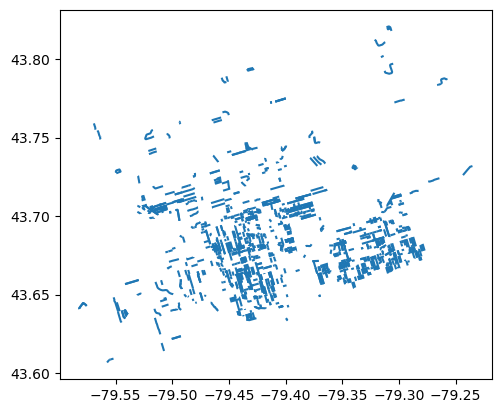

In [49]:
gdf.plot()

In [50]:
missing = gdf_raw.index.difference(gdf.index)

print(missing)

Index([684], dtype='int64')


In [51]:
gdf_raw.loc[[684]]

,calm_id,street,intersecti,intersec_1,spd_hump,traf_islan,spd_cush,Installed,geometry
684,1727.0,Kennedy Avenue,Glenwood Avenue,Evelyn Crescent,0.0,2.0,0.0,2018,None


In [52]:
gdf.head()

,calm_id,street,intersecti,intersec_1,spd_hump,traf_islan,spd_cush,Installed,geometry,NeighbourhoodPortion,Neighbourhood
0,1.0,Oakridge Drive,Brimley Rd,McCowan Rd,8.0,0.0,0.0,2004,"LINESTRING (-79.24361 43.72611, -79.24306 43.7...",1.000000,123
1,3.0,Atlas Avenue,Gloucester Grove,Eglinton Avenue West,2.0,0.0,0.0,1999,"LINESTRING (-79.43774 43.69669, -79.43816 43.6...",0.995234,107
80,83.0,Appleton Avenue,St. Clair Avenue West,Glenhurst Avenue,2.0,0.0,0.0,2006,"LINESTRING (-79.43754 43.67919, -79.43776 43.6...",0.752505,107
82,99.0,Cedric Avenue,Holland Park Avenue,Jesmond Avenue,3.0,0.0,0.0,1998,"LINESTRING (-79.43638 43.68679, -79.43703 43.6...",1.000000,107
89,114.0,O'Leary Avenue,Glenholme Avenue,Oakwood Avenue,3.0,0.0,0.0,1998,"LINESTRING (-79.43821 43.68593, -79.43875 43.6...",1.000000,107


In [54]:
store_context_data(gdf, STORE_NAME)

# Traffic Beacon

In [55]:
FILE_NAME = 'Traffic Beacon.geojson'
STORE_NAME = 'Traffic Beacon.csv'

gdf = geopandas.read_file(get_raw_path(FILE_NAME))
gdf = gdf.to_crs(functions.CRS)
gdf.head()

,_id,PX,MAIN_STREET,MIDBLOCK_ROUTE,SIDE1_STREET,SIDE2_STREET,PRIVATE_ACCESS,ADDITIONAL_INFO,OBJECTID,GEO_ID,NODE_ID,MI_PRINX,geometry
0,1,7002,WILLIAM R ALLEN RD,150m NORTH OF,TRANSIT RD,,,,2989,442309,0,2989,MULTIPOINT (-79.45546 43.74287)
1,2,7003,ARROW RD,355m NORTH OF,LIDO RD,,,,2990,11267778,0,2990,MULTIPOINT (-79.52922 43.74447)
2,3,7004,BANBURY RD,,AMES CRCL,BARRYDALE CRES,,,2991,441245,0,2991,MULTIPOINT (-79.36529 43.74974)
3,4,7005,ARROW RD,50m SOUTH OF,DEERHIDE CRES,,,NORTH OF TTC BUS DEPOT,2992,11267778,0,2992,MULTIPOINT (-79.53037 43.74764)
4,5,7006,AVENUE RD,,OTTER CRES,,,,2993,8344078,0,2993,MULTIPOINT (-79.41458 43.71836)


In [57]:
gdf_raw = gdf.copy()
gdf = add_neighbourhood_column(gdf)

Joining now using: 'how=inner', 'predicate=within'


In [58]:
missing = gdf_raw.index.difference(gdf.index)
print(missing)

Index([], dtype='int64')


In [59]:
store_context_data(gdf, STORE_NAME)

# Traffic Signals
A couple points lost at the very outscirts of Toronto

In [60]:
FILE_NAME = 'Traffic Signal.geojson'
STORE_NAME = 'Traffic Signals.csv'

gdf = geopandas.read_file(get_raw_path(FILE_NAME))
gdf = gdf.to_crs(functions.CRS)
gdf.head()

,_id,PX,MAIN_STREET,MIDBLOCK_ROUTE,SIDE1_STREET,SIDE2_STREET,PRIVATE_ACCESS,ADDITIONAL_INFO,ACTIVATIONDATE,SIGNALSYSTEM,...,MI_PRINX,BICYCLE_SIGNAL,UPS,LED_BLANKOUT_SIGN,LPI_NORTH_IMPLEMENTATION_DATE,LPI_SOUTH_IMPLEMENTATION_DATE,LPI_EAST_IMPLEMENTATION_DATE,LPI_WEST_IMPLEMENTATION_DATE,LPI_COMMENT,geometry
0,1,0002,JARVIS ST,,FRONT ST E,LOWER JARVIS ST,,,,TransSuite,...,1,0.0,0.0,0.0,,,,,,MULTIPOINT (-79.37146 43.64945)
1,2,0003,KING ST E,,JARVIS ST,,,,,TransSuite,...,2,0.0,0.0,1.0,,,,,,MULTIPOINT (-79.37191 43.65046)
2,3,0004,JARVIS ST,,ADELAIDE ST E,,,,,TransSuite,...,3,1.0,0.0,0.0,,,,,,MULTIPOINT (-79.37237 43.65153)
3,4,0005,JARVIS ST,,RICHMOND ST E,,,,,TransSuite,...,4,0.0,1.0,0.0,,,,,,MULTIPOINT (-79.37283 43.65270)
4,5,0006,JARVIS ST,,QUEEN ST E,,,,,TransSuite,...,5,0.0,0.0,0.0,,,,,,MULTIPOINT (-79.37325 43.65373)


In [63]:
gdf_raw = gdf.copy()
gdf = add_neighbourhood_column(gdf)

missing = gdf_raw.index.difference(gdf.index)
print(missing)

Joining now using: 'how=inner', 'predicate=within'
Index([1395, 1474, 1677, 1883, 1993, 2307, 2452], dtype='int64')


In [67]:
gdf_raw.loc[missing].explore()

In [68]:
store_context_data(gdf, STORE_NAME)

# Red light Cameras

In [71]:
FILE_NAME = 'Red Light Cameras Data.geojson'
STORE_NAME = 'Red Light Cameras.csv'

gdf = geopandas.read_file(get_raw_path(FILE_NAME))
gdf = gdf.to_crs(functions.CRS)
gdf.head()

,_id,INTERSECTION_ID,LINEAR_NAME_FULL_1,LINEAR_NAME_FULL_2,MI_PRINX,OBJECTID,ID,CLIENT_STREET_1,CLIENT_STREET_2,RLC,...,DISTRICT,WARD_1,WARD_2,WARD_3,WARD_4,POLICE_DIVISION_1,POLICE_DIVISION_2,POLICE_DIVISION_3,ACTIVATION_DATE,geometry
0,1,13465959,Richmond St E,Parliament St,1,1,1,RICHMOND ST E,PARLIAMENT ST,6001,...,Toronto and East York,Toronto Centre(13),,,,51,,,2007-11-09 05:00:00,MULTIPOINT (-79.36402 43.65456)
1,2,13467993,Lake Shore Blvd W,York St,2,2,2,LAKE SHORE BLVD W,YORK ST,6002,...,Toronto and East York,Spadina-Fort York(10),,,,52,,,2007-11-09 05:00:00,MULTIPOINT (-79.38087 43.64146)
2,3,13444656,Steeles Ave W,Carpenter Rd,3,3,3,STEELES AVE W,CARPENTER RD,6003,...,North York,York Centre(6),,,,32,,,2007-11-09 05:00:00,MULTIPOINT (-79.44759 43.79201)
3,4,13444138,Steeles Ave W,Hilda Ave,4,4,4,STEELES AVE W,HILDA AVE,6004,...,North York,Willowdale(18),,,,32,,,2007-11-09 05:00:00,MULTIPOINT (-79.42927 43.79601)
4,5,13451893,Albion Rd,Silverstone Dr,5,5,5,ALBION RD,SILVERSTONE DR,6005,...,Etobicoke York,Etobicoke North(1),,,,23,,,2007-11-09 05:00:00,MULTIPOINT (-79.60009 43.74295)


In [72]:
gdf_raw = gdf.copy()
gdf = add_neighbourhood_column(gdf)

missing = gdf_raw.index.difference(gdf.index)
print(missing)

Joining now using: 'how=inner', 'predicate=within'
Index([], dtype='int64')


In [73]:
store_context_data(gdf, STORE_NAME)